In [9]:
# Импортируем необходимые библиотеки
from lightautoml.automl.presets.tabular_presets import TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.automl.base import AutoML
from lightautoml.automl.blend import WeightedBlender
from lightautoml.report.report_deco import ReportDeco

import pandas as pd
from sklearn.metrics import  roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import shap

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
colors = ["#A115FE", "#8F00FF", "#4d0585", "#591878", "#6e1f78", "#7b469c", "#2c0652",
          "#29AB50", "#22753b", "#ECE919", "#7a781d", "#0F91D0", "#0f3f75"]
sns.set_palette(sns.color_palette(colors))

In [10]:
def feature_drop(data):
    return data.copy().loc[:, data.nunique() != 1].drop(columns=["feature756", "feature642"])
    



def get_categorical_columns(df):
    binar = set(df.columns[df.nunique() == 2])
    cat_indexes = df[df.columns[~(df.nunique() == 2)]].nunique().div((df[df.columns[~(df.nunique() == 2)]] != 0).sum().values, axis=0) * 100 <= 0.15


    potentially_categorical = binar.union(set(cat_indexes[cat_indexes == True].index))

    # из потенциально категориальных попробуем вычесть колонки, которые могут быть численными

    potentially_continuous = set(df.columns[(df.min(axis=0) == 0) & \
                                (df.max(axis=0) != 1) & \
                                df.isin([1]).any() & \
                                df.isin([2]).any() & \
                                df.isin([3]).any() & \
                                df.isin([4]).any() & \
                                df.isin([5]).any() & \
                                (df.nunique() <= 500)])

    cat_cols = list(potentially_categorical - potentially_continuous)
    cat_features_tmp = list(set(cat_cols) - set(['feature488', 'feature506', 'feature475', 'feature474', 'feature559', 'feature560', 'feature553']))

    return cat_features_tmp



def get_df1():

    file_path = "Data/train_ai_comp_final_dp.parquet"
    pf = ParquetFile(file_path)
    df = pf.to_pandas()
    return df




def remove_highly_correlated_features(X_train, shap_df, threshold=0.9):
    import pandas as pd
    import numpy as np

    df_copy = X_train.copy()

    # Если размер данных больше 100000 строк, делаем выборку
    if len(df_copy) > 100000:
        df_sample = df_copy.sample(n=100000, random_state=1)
    else:
        df_sample = df_copy

    corr_matrix = df_sample.corr().abs()

    # Получаем пары фич с высокой корреляцией
    high_corr_var = np.where(corr_matrix > threshold)
    high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if
                     x != y and x < y]

    # Подготавливаем список фич для удаления
    features_to_remove = []

    for feature_a, feature_b in high_corr_var:
        # Получаем SHAP значения для каждой фичи
        shap_a = shap_df.loc[shap_df['feature'] == feature_a, 'shap_importance'].values[0]
        shap_b = shap_df.loc[shap_df['feature'] == feature_b, 'shap_importance'].values[0]

        # Удаляем фичу с меньшим SHAP значением
        if shap_a < shap_b:
            features_to_remove.append(feature_a)
        else:
            features_to_remove.append(feature_b)

    # Удаляем дубликаты в списке фич для удаления
    features_to_remove = list(set(features_to_remove))

    # Возвращаем обновлённый DataFrame без удалённых фич
    return features_to_remove


def get_shap_feature(X_train, y_train, X_val, classifiers):
    import numpy as np
    import pandas as pd
    import shap

    # Список для хранения результатов по каждой модели
    models_shap_values = []

    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        X_sample = shap.utils.sample(X_train, 10000)  # Выборка из 100 наблюдений
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_sample)

        if isinstance(shap_values, list):
            # Для бинарной классификации выбираем SHAP значения для класса "1"
            shap_values = shap_values[1]


        # Создаем DataFrame с SHAP значениями и фильтруем значимые признаки
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'shap_importance': np.abs(shap_values).mean(axis=0)
        }).query("shap_importance > 0")

        # Усредняем оставшиеся SHAP значения для каждой фичи
        feature_importance = feature_importance.groupby('feature', as_index=False).mean()

        models_shap_values.append(feature_importance)

    # Объединяем SHAP значения из всех моделей
    final_shap_df = pd.concat(models_shap_values).groupby('feature', as_index=False).mean()

    return final_shap_df


def download_raw_data_from_drive_and_open_in_pandas(file_id="1cS6pE2ZD127iSVEiLRDzGd_b65J7GTd9",
                                                    file_path="Data/raw_data.parquet"):
    import pandas as pd
    import gdown
    # скачивает файл
    gdown.download(id=file_id, output=file_path)

    return pd.read_parquet(file_path)

In [16]:
df = pd.read_csv("/kaggle/input/test-and-train/train.csv")

In [18]:
X = df.drop(columns=["target", "id"])
y = df["target"]

In [19]:
X = df.drop(columns=['target', "id"])
y = df['target']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [20]:
classifiers = [
    lgb.LGBMClassifier(n_estimators=50, random_state=42, max_depth=8, learning_rate=0.01),
    XGBClassifier(n_estimators=50, random_state=42, max_depth=8, learning_rate=0.01),
    CatBoostClassifier(iterations=50, learning_rate=0.01, depth=8, loss_function='Logloss', verbose=500)
]
shap_df  = get_shap_feature(X_train, y_train, X_test, classifiers)


2024-03-13 15:54:43.198286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 15:54:43.198410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 15:54:43.340359: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


0:	learn: 0.6776316	total: 1.56s	remaining: 1m 16s
49:	learn: 0.2798941	total: 1m 6s	remaining: 0us


In [21]:
shap_df.sort_values(by="shap_importance", ascending=False)

,feature,shap_importance
580,feature994,4.247348e-02
204,feature341,3.698404e-02
190,feature319,3.573700e-02
6,feature1004,3.263487e-02
567,feature954,1.416040e-02
...,...,...
182,feature305,4.337323e-07
502,feature869,4.190074e-07
327,feature51,3.749351e-07
376,feature57,3.704048e-07


In [22]:
feature = shap_df["feature"].values
X_test, X_train= X_test[feature], X_train[feature]
without_drop = shap_df.sort_values(by = "shap_importance", ascending = False)["feature"].head(10)
columns_to_remove = remove_highly_correlated_features(X_train.drop(columns=without_drop.values), shap_df, threshold=0.9)
X_train, X_val, X_test = X_train.drop(columns=columns_to_remove), X_val.drop(columns=columns_to_remove), X_test.drop(columns=columns_to_remove)
category = get_categorical_columns(X_train)

In [23]:
feature_final = X_train.columns

In [24]:
train = pd.concat([X_train, y_train], axis=1)
validate = pd.concat([X_val, y_val], axis=1)

In [ ]:
>>> import torch

>>> torch.cuda.is_available()
True

>>> torch.cuda.device_count()
1

>>> torch.cuda.current_device()


>>>torch.cuda.device(0)

>>> torch.cuda.get_device_name(0)
'GeForce GTX 950M'

In [27]:
import torchorch.cuda.is_available()

True

In [32]:
import torch

if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")


GPU is available: Tesla P100-PCIE-16GB


In [30]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [33]:
task = Task('binary', metric='auc')

# Параметры для инициализации TabularUtilizedAutoML
automl_params = {
    'task': task,
    'timeout': 3600 * 2,  # Увеличиваем время до 4 часов для глубокого поиска
    'cpu_limit': 8,  # Увеличиваем количество CPU для ускорения обработки
    'memory_limit': 32,  # Увеличиваем объем доступной памяти
    'gpu_ids': '0',  # Использование GPU, если доступно
    'reader_params': {
        'cv': 5,  # Кросс-валидация на 5 фолдах для улучшения оценки стабильности модели
        'random_state': 42,
        'n_jobs': 4,  # Использование дополнительных потоков для предобработки данных
    },
    'general_params': {
        'use_algos': [['lgb', 'lgb_tuned', 'catboost', 'catboost_tuned', 'xgboost', 'xgboost_tuned']],  # Использование и настройка основных алгоритмов
    },
    'tuning_params': {
        'max_tuning_time': 1800,  # Увеличиваем время тюнинга каждого алгоритма
        'max_tuning_iter': 100,  # Увеличиваем количество итераций тюнинга
    },
    'selection_params': {
        'mode': 2,  # Полный перебор моделей для лучшего выбора
    },
}

# Создаем экземпляр TabularUtilizedAutoML с заданными параметрами
automl = TabularUtilizedAutoML(**automl_params)

# Определение ролей
roles = {
    'target': 'target',  # Укажите имя столбца с целевой переменной
    # Добавьте другие роли, если это необходимо, например, для указания категориальных признаков
}

# Обучение модели и получение предсказаний
# Подставьте свои данные вместо train_data и validate_data
oof_pred = automl.fit_predict(train, roles=roles, valid_data=validate)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

In [34]:
import pickle

#Сохранение модели
with open('automl_model_v3.pkl', 'wb') as f:
    pickle.dump(automl, f)


with open('automl_model_v3.pkl', 'rb') as f:
    loaded_automl = pickle.load(f)


In [35]:
predict = loaded_automl.predict(X_val)
predict.data[:, 0]

array([0.01500543, 0.01546984, 0.0082615 , ..., 0.17327966, 0.02566291,
       0.02812326], dtype=float32)

In [36]:
y_train_pred = loaded_automl.predict(X_train).data[:, 0]
y_val_pred = loaded_automl.predict(X_val).data[:, 0]

predictions = np.where(y_val_pred > 0.05, 1, 0)

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_val, y_val_pred)
print(f"roc-auc train {roc_auc_train}")
print(f"roc-auc test {roc_auc_test}")
print(classification_report(y_val, predictions))

roc-auc train 0.9052613112065828
roc-auc test 0.743671739206079
              precision    recall  f1-score   support

           0       0.98      0.83      0.89     25016
           1       0.10      0.49      0.16       965

    accuracy                           0.81     25981
   macro avg       0.54      0.66      0.53     25981
weighted avg       0.94      0.81      0.87     25981



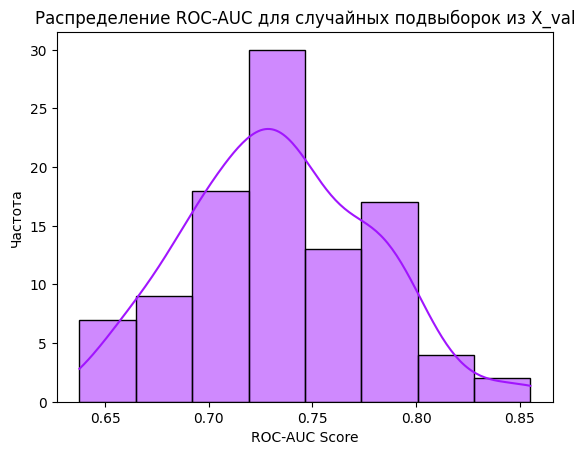

5-й квантиль: 0.6622644216512542
95-й квантиль: 0.8017033926937601


In [37]:
seed = 42
rng = np.random.RandomState(seed)

roc_auc_scores = []

for _ in range(100):  # Повторяем 100 раз
    # Выбираем случайные 1000 элементов из X_val и соответствующие метки y_val с помощью созданного генератора
    sample_indices = rng.choice(X_test.index, size=1000, replace=False)
    X_val_sample = X_test.loc[sample_indices]
    y_val_sample = y_test.loc[sample_indices]
    
    # Выполняем предсказание для выборки
    y_pred_sample = loaded_automl.predict(X_val_sample).data[:, 0]
    
    # Вычисляем roc_auc и добавляем в список
    roc_auc = roc_auc_score(y_val_sample, y_pred_sample)
    roc_auc_scores.append(roc_auc)

# Визуализация распределения roc_auc с помощью гистограммы
sns.histplot(roc_auc_scores, kde=True)
plt.title('Распределение ROC-AUC для случайных подвыборок из X_val')
plt.xlabel('ROC-AUC Score')
plt.ylabel('Частота')
plt.show()

# Вычисление 5-го и 95-го квантилей
quantile_5 = np.percentile(roc_auc_scores, 5)
quantile_95 = np.percentile(roc_auc_scores, 95)

print(f"5-й квантиль: {quantile_5}")
print(f"95-й квантиль: {quantile_95}")

In [38]:
test = pd.read_csv("/kaggle/input/test-and-train/test.csv")
id = df["id"].values
df = df[feature_final]
y_pred = loaded_automl.predict(df).data[:, 0]
predictions = np.where(y_pred > 0.03, 1, 0)

In [39]:
submit = pd.DataFrame({
    "id": id,
    "target_bin":predictions,
    "target_prob": y_pred
})
submit.to_csv("automl-3.csv")